In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import datetime

def obtener_tiempo(dfr):
    #Esta funcion permite obtener una columna Datetime a partir del agno, dia, hora y minuto de los datos iniciales
    dfr['Day'] = pd.to_datetime(dfr['Day'], format='%j').dt.strftime('%m-%d')
    dfr['Hour'] = dfr['Hour'].astype(str).str.zfill(2)
    dfr['Datetime'] = pd.to_datetime(dfr[['Year','Day', 'Hour', 'Minute']]
                   .astype(str).apply(' '.join, 1), format='%Y %m-%d %H %M') 
    return dfr

def sustituir(dfr):
    #Sustitucion de los valores 9999... por NaN (sabemos que la fila 2 son todo valores nulos para cada variable)
    valores_null = dfr.iloc[2, 4:]
    for i in range(len(valores_null)):
        dfr.iloc[:,i+4] = dfr.iloc[:,i+4].replace(valores_null[i], np.nan)
    return dfr

def imputar_por_interpolacion(dfr):
    #Sustituye los valores NaN por valores aproximados mediante el metodo de interpolacion
    dfr = dfr.interpolate(method='linear', limit_direction='forward')
    return dfr

def imputar_por_KNND(dfr):
    #Este metodo es para imputar las filas que no se hayan podido imputar con interpolacion (primera fila)
    imputer = KNNImputer(n_neighbors=3, weights = 'distance')
    dfr[:] = imputer.fit_transform(dfr)
    return dfr

def normalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    dfr[:] = standard_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def desnormalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores desnormalizados
    x = dfr.values
    standard_scaler = preprocessing.StandardScaler()
    dfr[:] = standard_scaler.inverse_transform(x)
    return dfr

def eliminar_gaps(dfr, n):
    #Eliminacion de filas donde alguna columna tiene N NaNs consecutivos
    for columna in range(dfr.shape[1]):
        mask = dfr.iloc[:,columna].notna()
        a = mask.ne(mask.shift()).cumsum()
        dfr = dfr[(a.groupby(a).transform('size') < n) | mask]
    return dfr

def NaN_consecutivos(dfr):
    #Obtencion del numero maximo de NaN consecutivos segun columna
    nans_consecutivos = []
    for columna in range(df.shape[1]):
        nan_columna = max(df.iloc[:,columna].isnull().astype(int).groupby(df.iloc[:,columna].notnull().astype(int).cumsum()).sum())
        nans_consecutivos.append(nan_columna)

    df_nans = pd.DataFrame(columns = ['Variable','Numero de nans consecutivos'])
    df_nans.iloc[:,0] = df.columns
    df_nans.iloc[:,1] = nans_consecutivos
    return df_nans

#**1-Montamos Drive para poder acceder a los datos y los leemos**

In [2]:
#Leemos los datos
#df = pd.read_csv('datos.csv', header=0)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
df = pd.read_csv('/content/drive/MyDrive/TFG_codigo/Prediccion_general/datos.csv', header=0)

#**2-Preprocesamos los datos y los normalizamos**

In [20]:
df = sustituir(df)
df = imputar_por_interpolacion(df)
imputar_por_KNND(df.iloc[:3, :])
df = obtener_tiempo(df)
df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
df = df.set_index('Datetime')
#df = normalizar_datos(df)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
1995-01-01 00:00:00,1.37,0.130,1.17,-0.670,311.453358,18.422649,17401.558702
1995-01-01 00:05:00,1.26,0.090,1.12,-0.500,311.400000,18.460000,17347.000000
1995-01-01 00:10:00,1.46,0.037,1.30,-0.586,311.560000,18.348000,17510.600000
1995-01-01 00:15:00,1.66,-0.016,1.48,-0.672,311.720000,18.236000,17674.200000
1995-01-01 00:20:00,1.86,-0.069,1.66,-0.758,311.880000,18.124000,17837.800000
...,...,...,...,...,...,...,...
2021-02-18 23:35:00,2.87,2.130,0.03,-1.860,364.100000,4.670000,58514.000000
2021-02-18 23:40:00,2.92,2.210,0.07,-1.880,364.900000,4.400000,62883.000000
2021-02-18 23:45:00,2.90,2.450,0.05,-1.540,364.100000,4.650000,58624.000000


In [21]:
columnas = df.columns

In [23]:
df.iloc[:,6]

Datetime
1995-01-01 00:00:00    17401.558702
1995-01-01 00:05:00    17347.000000
1995-01-01 00:10:00    17510.600000
1995-01-01 00:15:00    17674.200000
1995-01-01 00:20:00    17837.800000
                           ...     
2021-02-18 23:35:00    58514.000000
2021-02-18 23:40:00    62883.000000
2021-02-18 23:45:00    58624.000000
2021-02-18 23:50:00    67353.000000
2021-02-18 23:55:00    47244.000000
Name: Proton Temperature(K), Length: 2749248, dtype: float64

In [32]:
df_desnormalizado = df.copy()

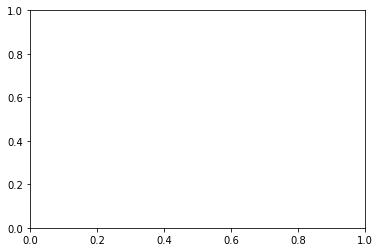

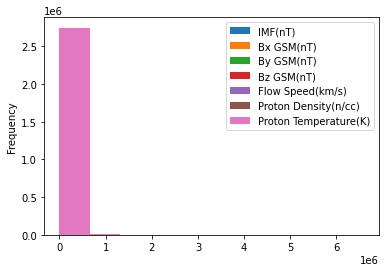

In [33]:
fig, ax = plt.subplots(figsize = (6,4))
df_desnormalizado.plot(kind = "hist")
plt.show()

In [11]:
columnas =df.columns

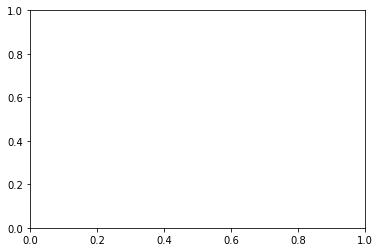

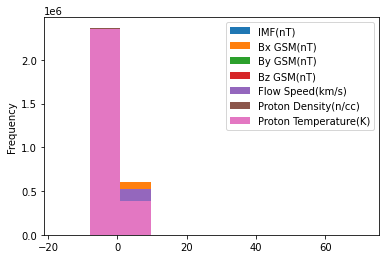

In [35]:
fig, ax = plt.subplots(figsize = (6,4))
df.plot(kind = "hist")
plt.show()

In [34]:
from sklearn.preprocessing import StandardScaler
x = df.values #returns a numpy array
scaler = StandardScaler()
scaler.fit(x)
df[:] = scaler.transform(x)

In [8]:
df.describe()

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
count,2.749248e+06,2.749248e+06,2.749248e+06,2.749248e+06,2.749248e+06,2.749248e+06,2.749248e+06
mean,3.227312e-14,6.042557e-16,1.689207e-16,4.572345e-16,-4.513848e-15,1.150877e-14,1.349792e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.819656e+00,-1.364708e+01,-1.216692e+01,-1.677141e+01,-1.945950e+00,-1.256570e+00,-9.760841e-01
25%,-6.304526e-01,-7.369751e-01,-6.337745e-01,-5.230980e-01,-7.441846e-01,-6.216045e-01,-6.326920e-01
50%,-2.219729e-01,-3.829689e-03,-1.008738e-02,1.334283e-03,-2.270070e-01,-2.766851e-01,-2.966127e-01
75%,3.512164e-01,7.293157e-01,6.313470e-01,5.227352e-01,5.203594e-01,2.896884e-01,3.047174e-01
max,2.179311e+01,1.047650e+01,1.357666e+01,1.949930e+01,6.429536e+00,1.287337e+01,7.117565e+01


#**3-Creacion de datasets**

In [ ]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 15))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    #for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
    #for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
    for i, (var, c) in enumerate(zip(df.columns, ['b','r','g','y','c','m','k'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

#===================================Parametros para obtener train_dataset y val_dataset====================================
TRAIN_SPLIT   = int(0.8 * int(df.shape[0]))
STEP          = 1
past_history  = 40
future_target = 4
BUFFER_SIZE   = 10000

#===================================PARAMETROS DE ENTRENAMIENTO====================================
LEARNING_RATE = 0.001       #Learning rate es la tasa de aprendizaje (mirar word para mas detalle)
EPOCHS        = 20          #Determina el numero de iteraciones que ser realizan sobre los datos de entrenamiento
PATIENCE      = 5
#EVALUATION_INTERVAL = 200
BATCH_SIZE    = 256
DROPOUT_LSTM  = 0.15

**3.1-Datasets para los modelos orientados a predicción de Bz y By**

In [ ]:
df_target = df.iloc[:, 2:4]
dataset = df_target.values

x_train_multi_bz_by, y_train_multi_bz_by = multivariate_multioutput_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi_bz_by, y_val_multi_bz_by = multivariate_multioutput_data(dataset, dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi_bz_by = tf.data.Dataset.from_tensor_slices((x_train_multi_bz_by, y_train_multi_bz_by))
train_data_multi_bz_by = train_data_multi_bz_by.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi_bz_by = tf.data.Dataset.from_tensor_slices((x_val_multi_bz_by, y_val_multi_bz_by))
val_data_multi_bz_by = val_data_multi_bz_by.batch(BATCH_SIZE).repeat()

**3.2-Datasets para los modelos orientados a predicción general**

In [ ]:
#Creacion de datasets de entrenamiento y validacion
dataset = df.values

x_train_multi, y_train_multi = multivariate_multioutput_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset, dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
df.iloc[TRAIN_SPLIT:]

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
2015-11-28 19:10:00,1.154999,1.504596,-1.490711,-1.326419,-1.150752,4.054406,-0.432971
2015-11-28 19:15:00,1.293355,1.504596,-1.620012,-1.390079,-1.129826,3.950538,-0.450771
2015-11-28 19:20:00,1.296649,1.529877,-1.336056,-1.681093,-1.120857,3.746722,-0.427859
2015-11-28 19:25:00,0.983701,1.052349,-1.381692,-1.671999,-1.074022,4.291538,-0.417174
2015-11-28 19:30:00,1.138528,1.277068,-1.394369,-1.380984,-1.084984,3.932900,-0.438127
...,...,...,...,...,...,...,...
2021-02-18 23:35:00,-0.930224,0.594484,0.002589,-0.550381,-0.621617,-0.347237,-0.352641
2021-02-18 23:40:00,-0.913753,0.616956,0.012730,-0.556443,-0.613645,-0.400151,-0.304812
2021-02-18 23:45:00,-0.920341,0.684372,0.007660,-0.453376,-0.621617,-0.351156,-0.351436


**PREDICCIONES A UN AÑO**

In [ ]:
df_val = df.loc['20200101':'20201231']
df.loc['20200101':'20201231']
dataset = df_val.values
df_val

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
2020-01-01 00:00:00,-0.396565,-0.826863,0.760648,-0.141142,-1.304211,-0.221811,-0.730363
2020-01-01 00:05:00,-0.416330,-0.728548,0.725154,-0.129016,-1.293748,0.005522,-0.676032
2020-01-01 00:10:00,-0.890694,0.566395,0.266262,0.204438,-1.283285,0.232855,-0.621701
2020-01-01 00:15:00,-0.801751,0.223698,0.276403,0.004366,-1.297236,0.424913,-0.611641
2020-01-01 00:20:00,-0.989519,0.027069,0.025407,-0.059294,-1.308197,0.487625,-0.695923
...,...,...,...,...,...,...,...
2020-01-01 23:35:00,-1.042226,0.383810,-0.144459,0.356008,-0.629588,-0.396231,-0.558251
2020-01-01 23:40:00,-1.029050,0.336058,-0.146994,0.516672,-0.635567,-0.413869,-0.546001
2020-01-01 23:45:00,-1.005990,0.322013,-0.195165,0.546986,-0.597701,-0.429547,-0.658221


In [ ]:
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset, dataset, 0,
                                                 None, past_history,
                                                 future_target, STEP)

In [ ]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(2199358, 40, 7, 1, 1)
(2199358, 4, 7, 1, 1)
(549806, 40, 7, 1, 1)
(549806, 4, 7, 1, 1)
Single window of past history : (40, 7, 1, 1)
Target temperature to predict : (4, 7, 1, 1)


#3-CARGAMOS LOS MODELOS

**MODELO BASELINE**

In [ ]:
#codigo baseline
def baseline(x_val, y_val):
  num_predicciones = len(y_val)
  timesteps_futuros = len(y_val[0])
  timesteps_pasados = len(x_val[0])
  variables = len(x_val[0][0])
  predicciones = np.zeros(shape=(y_val.shape))
  for prediccion in range(num_predicciones):
      dato = x_val[prediccion][timesteps_pasados-1]
      for num_timesteps_a_predecir in range(timesteps_futuros):
          predicciones[prediccion][num_timesteps_a_predecir] = dato
  return predicciones


In [ ]:
len(y_val_multi_bz_by[0])

4

**MODELO SIMPLE**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_simplificado(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**MODELO COMPLEJO**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
def build_model_complejo(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

**3.1-Modelos orientados a predicción de Bz y By**

In [ ]:
#Comparativa de modelos By_Bz
import pickle
modelo1 = build_model_complejo(x_train_multi_bz_by.shape[1], future_target, y_train_multi_bz_by.shape[2], x_train_multi_bz_by.shape[2])
modelo1.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/weights_Bz_By_base.h5')
history_1 = pickle.load(open('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/history_Bz_By_base.h5', "rb"))


modelo2 = build_model_complejo(x_train_multi_bz_by.shape[1], future_target, y_train_multi_bz_by.shape[2], x_train_multi_bz_by.shape[2])
modelo2.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/weights_Bz_By_base2.h5')
history_2 = pickle.load(open('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/history_Bz_By_base.h5', "rb"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**3.1.1-Arquitectura de los modelos**

In [ ]:
from keras.utils.vis_utils import plot_model
modelo_s = build_model_simplificado(40, 4, 7, 1)
modelo_s.summary()
tf.keras.utils.plot_model(modelo_s, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/arquitectura_simple.png')

In [ ]:
from keras.utils.vis_utils import plot_model
modelo_c = build_model_complejo(40, 4, 7, 1)
modelo_c.summary()
tf.keras.utils.plot_model(modelo_s, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/arquitectura_compleja.png')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 40, 1, 1, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 40, 1, 1, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 1, 1, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 40, 1, 1, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 1, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 1, 1, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NameError: ignored

**3.2-Modelos orientados a predicciones generales**

In [ ]:
import pickle
model_s_19 = build_model_simplificado(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
model_s_19.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/Modelo_simplificado_19E/weights_ms19.h5')
history_s19 = pickle.load(open('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/Modelo_simplificado_19E/history_ms19', "rb"))


model_s = build_model_simplificado(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
model_s.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/modelo_simplificado_100epochs.h5')
history_s = pickle.load(open('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/historymodelo_simplificado_100epochs', "rb"))


model_c = build_model_complejo(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
model_c.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_pesos.h5')
history_c = pickle.load(open('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_history', "rb"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_c = build_model_complejo(40, 4, 7, 7)
model_c.load_weights('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_pesos.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
len(x_val_multi)

105364

In [ ]:
predicciones_1ano = model_c.predict(x_val_multi, verbose=1)

3293/3293 [==============================] - 333s 97ms/step


In [ ]:
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/predicciones_1agno', predicciones_1ano)

In [ ]:
predicciones_1ano = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/predicciones_1agno.npy')

In [ ]:
predicciones_baseline = baseline(x_val_multi, y_val_multi)

**3.3Imprimir arquitectura de los modelos**

3.3.1-Modelo Simple


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
input_timesteps = 40
output_timesteps = 4
num_links = num_inputs = 7
model = Sequential()
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
model.add(ConvLSTM2D(name ='conv_lstm_1',
                      filters = 64, kernel_size = (10, 1),                       
                      padding = 'same', 
                      return_sequences = False))

model.add(Dropout(0.30, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))


model.add(Flatten())
model.add(RepeatVector(output_timesteps))
model.add(Reshape((output_timesteps, num_inputs, 1, 64)))


model.add(ConvLSTM2D(name ='conv_lstm',
                      filters = 64, kernel_size = (5, 1), 
                      padding='same',
                      return_sequences = True))

model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
model.add(Dense(units=1, name = 'dense_2'))

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/arquitectura.png' )

3.3.2-Modelo complejo

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
model.add(ConvLSTM2D(name ='conv_lstm_1',
                      filters = 64, kernel_size = (10, 1),                       
                      padding = 'same', 
                      return_sequences = True))

model.add(Dropout(0.30, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))

model.add(ConvLSTM2D(name ='conv_lstm_2',
                      filters = 64, kernel_size = (5, 1), 
                      padding='same',
                      return_sequences = False))

model.add(Dropout(0.20, name = 'dropout_2'))
model.add(BatchNormalization(name = 'batch_norm_2'))

model.add(Flatten())
model.add(RepeatVector(output_timesteps))
model.add(Reshape((output_timesteps, num_inputs, 1, 64)))

model.add(ConvLSTM2D(name ='conv_lstm_3',
                      filters = 64, kernel_size = (10, 1), 
                      padding='same',
                      return_sequences = True))

model.add(Dropout(0.20, name = 'dropout_3'))
model.add(BatchNormalization(name = 'batch_norm_3'))

model.add(ConvLSTM2D(name ='conv_lstm_4',
                      filters = 64, kernel_size = (5, 1), 
                      padding='same',
                      return_sequences = True))

model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/arquitectura.png' )

#4-Evaluación de los modelos y comparativa

In [ ]:
def plot_train_history(history, title):
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

**4.1-Históricos de los modelos orientados a la predicción de Bz y By**

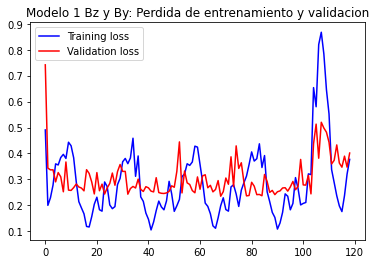

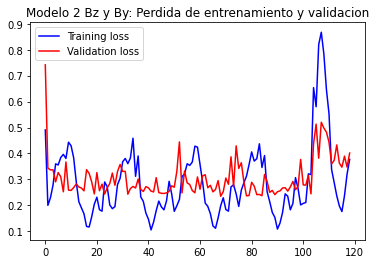

In [ ]:
#Modelos Bz y By
plot_train_history(history_1, 'Modelo 1 Bz y By: Perdida de entrenamiento y validacion')
plot_train_history(history_2, 'Modelo 2 Bz y By: Perdida de entrenamiento y validacion')

**4.1-Históricos de los modelos orientados a predicción general**

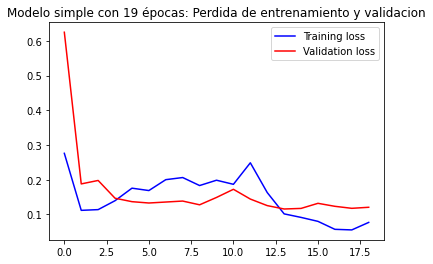

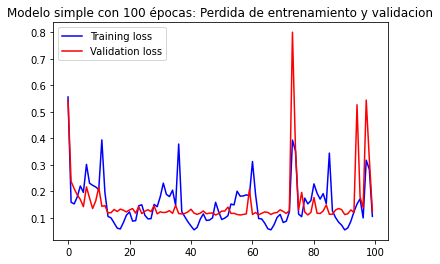

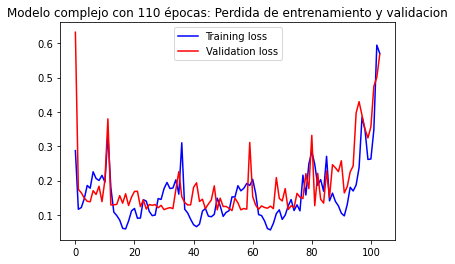

In [ ]:
#Modelos todas variables
plot_train_history(history_s19, 'Modelo simple con 19 épocas: Perdida de entrenamiento y validacion')
plot_train_history(history_s, 'Modelo simple con 100 épocas: Perdida de entrenamiento y validacion')
plot_train_history(history_c, 'Modelo complejo con 110 épocas: Perdida de entrenamiento y validacion')

**4.2.1-Predicciones de los modelos orientados a Bz y By**

In [ ]:
#Obtneemos las predicciones de los modelos Bz y By
variables = df.columns
predicciones_1 = modelo1.predict(x_val_multi_bz_by, verbose=1)
predicciones_2 = modelo2.predict(x_val_multi_bz_by, verbose=1)




17182/17182 [==============================] - 1566s 91ms/step


ValueError: ignored

**4.2.1.1Guardamos las predicciones bz_by realizadas**

In [ ]:
#Guardamos las predicciones realizadas
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/predicciones_Bz_By_base', predicciones_1)
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/predicciones_Bz_By_base2', predicciones_2)
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/predicciones_Bz_By_baseline', predicciones_baseline_bz_by)

**4.2.1.2-Cargar las predicciones calculadas**

In [ ]:
predicciones_1 = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/predicciones_Bz_By_base.npy')
predicciones_2 = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/predicciones_Bz_By_base2.npy')
predicciones_baseline_bz_by = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Bz_By/predicciones_Bz_By_baseline.npy')

In [ ]:
predicciones_baseline_bz_by = baseline(x_val_multi_bz_by, y_val_multi_bz_by)
predicciones_bz_by   = [predicciones_baseline_bz_by, predicciones_1, predicciones_2]
nombre_modelos_bz_by = ['Baseline', 'Modelo1', 'Modelo2']
variables_bz_by      = variables[2:4]

**4.2.1-Predicciones de los modelos orientados a predicción general**

In [ ]:
#Obtenemos las predicciones de ambos modelos
predicciones_s  = model_s.predict(x_val_multi, verbose=1)
predicciones_c  = model_c.predict(x_val_multi, verbose=1)
predicciones_19 = model_s_19.predict(x_val_multi, verbose=1)
predicciones_baseline = baseline(x_val_multi, y_val_multi)


predicciones   = [predicciones_baseline, predicciones_19, predicciones_s, predicciones_c]
nombre_modelos = ['Baseline', 'Simple_19E', 'Simple_100E', 'Complejo_110E']
variables      = variables

17182/17182 [==============================] - 799s 46ms/step


**4.2.2.1-Guardamos las predicciones de los modelos realizadas**

In [ ]:
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/Modelo_simplificado_19E/predicciones_ms19', predicciones_19)
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/predicciones_simplificado_100epochs', predicciones_s)
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_predicciones', predicciones_c)
np.save('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_baseline/predicciones', predicciones_baseline)

**4.2.2.2-Cargar las predicciones generales**

In [ ]:
#predicciones_19       = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/Modelo_simplificado_19E/predicciones_ms19.npy')
predicciones_s        = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/predicciones_simplificado_100epochs.npy')
#predicciones_c        = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_predicciones.npy')
#predicciones_baseline = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_baseline/predicciones.npy')

predicciones   = [predicciones_baseline, predicciones_19, predicciones_s, predicciones_c]
nombre_modelos = ['Baseline', 'Simple_19E', 'Simple_100E', 'Complejo_110E']
variables      = variables

In [ ]:
predicciones_s        = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_simplificado/predicciones_simplificado_100epochs.npy')

predicciones   = [predicciones_s]
nombre_modelos = ['Simple_100E']
variables      = df.columns

In [ ]:
predicciones_c        = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/modelo_complejo_150epochs_predicciones.npy')
predicciones   = [predicciones_c]
nombre_modelos = ['Complejo_150E']
variables      = df.columns

In [ ]:
predicciones_baseline = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_baseline/predicciones.npy')
predicciones   = [predicciones_baseline]
nombre_modelos = ['Baseline']
variables      = df.columns

In [ ]:
predicciones = [predicciones_1ano, predicciones_baseline]
nombre_modelos = ['Complejo', 'Baseline']
variables      = df.columns

**4.3-Comparativa de los modelos**

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def obtener_metricas(y_val, y_preds, nombre_modelos):
    #Aplanamos los datos para que se puedan calcular las metricas
    y_val = np.squeeze(y_val)
    y_val = y_val.ravel()
    datos_mse  = []
    datos_r2   = []
    datos_rmse = []
    datos_mae  = []
    columnas   = []
    for modelo in range(len(nombre_modelos)):
        y_pred = np.squeeze(y_preds[modelo])
        y_pred = y_pred.ravel()
        #Calculamos las metricas
        r2   = r2_score(y_val, y_pred)
        mse  = mean_squared_error(y_val, y_pred)
        mae  = mean_absolute_error(y_val, y_pred)
        rmse = mse**0.5
        #Los anadimos a las listas correspondientes
        datos_mse.append(mse)
        datos_r2.append(r2)
        datos_rmse.append(rmse)
        datos_mae.append(mae)
        #Creamos una columna por modelo
        columnas.append(nombre_modelos[modelo])

    #Mostramos los resultados en forma de df
    nombres_metricas = ['R2', 'RMSE', 'MSE', 'MAE']
    valores = [datos_r2, datos_rmse, datos_mse, datos_mae]

    metricas = pd.DataFrame(valores, columns = columnas, index = nombres_metricas)
    return metricas



def desglose_por_timestep(y_val, predicciones):
    num_predicciones = predicciones.shape[0]
    num_timesteps   = predicciones.shape[1]

    timesteps_y_val  = []
    timesteps_y_pred = []
    
    #Creamos 4 listas, una para cada timestep
    for lista_timestep in range(num_timesteps):
        timestep_valN = []
        timesteps_y_val.append(timestep_valN)
        timestep_predN = []
        timesteps_y_pred.append(timestep_predN)
    #Metemos en cada una de los 4 listas, el correspondiente timestep de cada prediccion
    for prediccion in range(num_predicciones):
        for timestep in range(num_timesteps):
            timesteps_y_pred[timestep].append(predicciones[prediccion][timestep])
            timesteps_y_val[timestep].append(y_val[prediccion][timestep])
    
    return timesteps_y_val, timesteps_y_pred

def comparacion_modelos_timestep(y_val, predicciones, nombre_modelos):
  timesteps_y_preds = []
  for modelo in range(len(nombre_modelos)):
      timesteps_y_val, timesteps_y_pred_modelo = desglose_por_timestep(y_val, predicciones[modelo])
      timesteps_y_preds.append(timesteps_y_pred_modelo)
  for timestep in range(4):
      timesteps_modelos = []
      for modelo in range(len(nombre_modelos)):
          timesteps_modelos.append(timesteps_y_preds[modelo][timestep])
      print("=========TIMESTEP: ",timestep,"=========\n",obtener_metricas(timesteps_y_val[timestep], timesteps_modelos, nombre_modelos))


def comparacion_modelos_timestep_variables(y_val, predicciones, nombre_modelos, nombre_variables):
  desglose_preds = []
  for modelo in range(len(nombre_modelos)):
      desglose_val, desglose_pred = agrupar_variables_timestep(y_val, predicciones[modelo])
      desglose_preds.append(desglose_pred)
  
  for paso in range(4):
    print("===================TIMESTEP ", paso,"===================")
    for variable in range(len(nombre_variables)):
        variableN_modelos = []
        for modelo in range(len(nombre_modelos)):
          variableN_modelos.append(desglose_preds[modelo][paso][variable])
        print("=====VARIABLE", nombre_variables[variable],"====")
        print(obtener_metricas(desglose_val[paso][variable], variableN_modelos, nombre_modelos))


def agrupar_variables_timestep(y_val, y_pred):
    num_predicciones = y_val.shape[0]
    num_timesteps    = y_val.shape[1]
    num_variables    = y_val.shape[2]
    #Creacion de listas
    desglose_val  = []
    desglose_pred = []
    for paso in range(num_timesteps):
        timestepN_val  = []
        timestepN_pred = []
        for i in range(num_variables):
            timestepN_varI_val = []
            timestepN_val.append(timestepN_varI_val)
            
            timestepN_varI_pred = []
            timestepN_pred.append(timestepN_varI_pred)
            
        desglose_val.append(timestepN_val)
        desglose_pred.append(timestepN_pred)
    
    #Desglose
    for prediccion in range(num_predicciones):
        for paso in range(num_timesteps):
            for var in range(num_variables):
                desglose_val[paso][var].append(y_val[prediccion][paso][var])
                desglose_pred[paso][var].append(y_pred[prediccion][paso][var])
    
    return desglose_val, desglose_pred




def resumen_comparativa(y_val, predicciones, nombre_modelos, variables):
    pd.set_option("display.max_rows", None, "display.max_columns", None)

    #1-Comparativa general de los modelos
    print("===================================================COMPARATIVA GENERAL DE LOS MODELOS===================================================")
    print(obtener_metricas(y_val, predicciones, nombre_modelos))

    #2-Comparativa por timestep de los modelos
    print("===================================================COMPARATIVA POR TIMESTEP DE LOS MODELOS===================================================")
    print(comparacion_modelos_timestep(y_val, predicciones, nombre_modelos))

    print("===================================================COMPARATIVA POR TIMESTEP Y VARIABLES DE LOS MODELOS===================================================")
    #3-Comparativa por timestep y variable de los modelos
    print(comparacion_modelos_timestep_variables(y_val, predicciones, nombre_modelos, variables))


In [ ]:
predicciones_baseline_bz_by = baseline(x_val_multi_bz_by, y_val_multi_bz_by)
predicciones_bz_by   = [predicciones_baseline_bz_by, predicciones_1, predicciones_2]
nombre_modelos_bz_by = ['Baseline', 'Modelo1', 'Modelo2']
variables_bz_by      = variables[2:4]

In [ ]:
variables = df.columns
predicciones_bz_by   = [predicciones_1]
nombre_modelos_bz_by = ['Modelo1']
variables_bz_by      = variables[2:4]

In [ ]:
resumen_comparativa(y_val_multi, predicciones, nombre_modelos, variables)

===================================================COMPARATIVA GENERAL DE LOS MODELOS===================================================
      Complejo  Baseline
R2    0.896133  0.891668
RMSE  0.233437  0.238400
MSE   0.054493  0.056835
MAE   0.138131  0.126089
===================================================COMPARATIVA POR TIMESTEP DE LOS MODELOS===================================================
=========TIMESTEP:  0 =========
       Complejo  Baseline
R2    0.948526  0.953552
RMSE  0.164334  0.156104
MSE   0.027006  0.024369
MAE   0.100424  0.081527
=========TIMESTEP:  1 =========
       Complejo  Baseline
R2    0.908846  0.907137
RMSE  0.218684  0.220725
MSE   0.047823  0.048720
MAE   0.129833  0.118143
=========TIMESTEP:  2 =========
       Complejo  Baseline
R2    0.876948  0.869465
RMSE  0.254081  0.261693
MSE   0.064557  0.068483
MAE   0.152518  0.142701
=========TIMESTEP:  3 =========
       Complejo  Baseline
R2    0.850209  0.836519
RMSE  0.280330  0.292861
MSE   0.078585

In [ ]:
resumen_comparativa(y_val_multi_bz_by, predicciones_bz_by, nombre_modelos_bz_by, variables_bz_by)

===================================================COMPARATIVA GENERAL DE LOS MODELOS===================================================
       Modelo1
R2    0.759001
RMSE  0.407081
MSE   0.165715
MAE   0.250251
===================================================COMPARATIVA POR TIMESTEP DE LOS MODELOS===================================================
=========TIMESTEP:  0 =========
        Modelo1
R2    0.883456
RMSE  0.283086
MSE   0.080138
MAE   0.170918
=========TIMESTEP:  1 =========
        Modelo1
R2    0.783588
RMSE  0.385757
MSE   0.148808
MAE   0.237352
=========TIMESTEP:  2 =========
        Modelo1
R2    0.712535
RMSE  0.444595
MSE   0.197665
MAE   0.280793
=========TIMESTEP:  3 =========
        Modelo1
R2    0.656422
RMSE  0.486054
MSE   0.236249
MAE   0.311941
None
===================================================COMPARATIVA POR TIMESTEP Y VARIABLES DE LOS MODELOS===================================================
===================TIMESTEP  0 ===================
====

**Por si queremos visualizar como predicen nuestros modelos**

In [ ]:
predicciones_tormentas = np.load('/content/drive/MyDrive/TFG_codigo/Prediccion_general/Modelo_Complejo/predicciones_tormenta.npy')

In [ ]:
def obtener_predicciones_variables(predicciones_tormentas, nombre_variables):
  num_predicciones = len(predicciones_tormentas)
  num_pasos        = len(predicciones_tormentas[0])
  num_variables    = len(predicciones_tormentas[0][0])

  lista_variables = []


  for variable in range(num_variables):
    valores_variable = []
    lista_variables.append(valores_variable)

  for predicciones in range(num_predicciones - 3744, num_predicciones, 4):
    for paso in range(num_pasos):
      for variable in range(num_variables):
        dato = np.squeeze(predicciones_tormentas[predicciones][paso][variable])
        lista_variables[variable].append(dato)

  return lista_variables



In [ ]:
prediccions_variables = obtener_predicciones_variables(predicciones_tormentas, variables)

In [ ]:
df_tormenta = df.loc['20180822':'201809032359']
df_tormenta

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
2018-08-22 00:00:00,-1.602239,-0.110571,0.022872,0.025585,1.149144,-0.311961,0.775502
2018-08-22 00:05:00,-1.401293,-0.138661,0.174991,-0.192675,1.157116,-0.313921,0.715325
2018-08-22 00:10:00,-1.167406,-0.397088,0.248515,-0.359402,1.095333,-0.321760,0.370105
2018-08-22 00:15:00,-1.065286,-0.427987,0.215556,-0.501878,1.040526,-0.296283,0.304477
2018-08-22 00:20:00,-1.035638,-0.239785,0.263726,-0.623134,1.030562,-0.304122,0.231601
...,...,...,...,...,...,...,...
2018-09-03 23:35:00,-0.880811,0.150665,-0.415738,0.762216,-0.921560,1.610573,-0.735968
2018-09-03 23:40:00,-0.805045,0.206844,-0.458838,0.795561,-0.898640,1.641930,-0.754710
2018-09-03 23:45:00,-0.716102,0.218080,-0.560250,0.795561,-0.846823,2.490510,-0.684374


In [ ]:
dataframe = pd.DataFrame(prediccions_variables)
dataframe = dataframe.T
dataframe.columns = variables
dataframe.set_index(df_tormenta.index, inplace=True)

In [ ]:
x = df_tormenta.values
df_tormenta[:] = scaler.inverse_transform(x)

In [ ]:
x = dataframe.values
dataframe[:] = scaler.inverse_transform(x)

In [ ]:
df_tormenta

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
2018-08-22 00:00:00,0.83,-0.38,0.11,0.04,541.8,4.85,161567.0
2018-08-22 00:05:00,1.44,-0.48,0.71,-0.68,542.6,4.84,156070.0
2018-08-22 00:10:00,2.15,-1.40,1.00,-1.23,536.4,4.80,124535.0
2018-08-22 00:15:00,2.46,-1.51,0.87,-1.70,530.9,4.93,118540.0
2018-08-22 00:20:00,2.55,-0.84,1.06,-2.10,529.9,4.89,111883.0
...,...,...,...,...,...,...,...
2018-09-03 23:35:00,3.02,0.55,-1.62,2.47,334.0,14.66,23498.0
2018-09-03 23:40:00,3.25,0.75,-1.79,2.58,336.3,14.82,21786.0
2018-09-03 23:45:00,3.52,0.79,-2.19,2.58,341.5,19.15,28211.0


In [ ]:
nombre_observado = variables+' observado'
nombre_predicho  = variables+ ' predicho'

In [ ]:
dataframe.columns = nombre_predicho
df_tormenta.columns = nombre_observado

In [ ]:
dataframe=dataframe.astype(float)
df_rellenar=df_rellenar.astype(float)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9f8abfa90>,
      dtype=object)

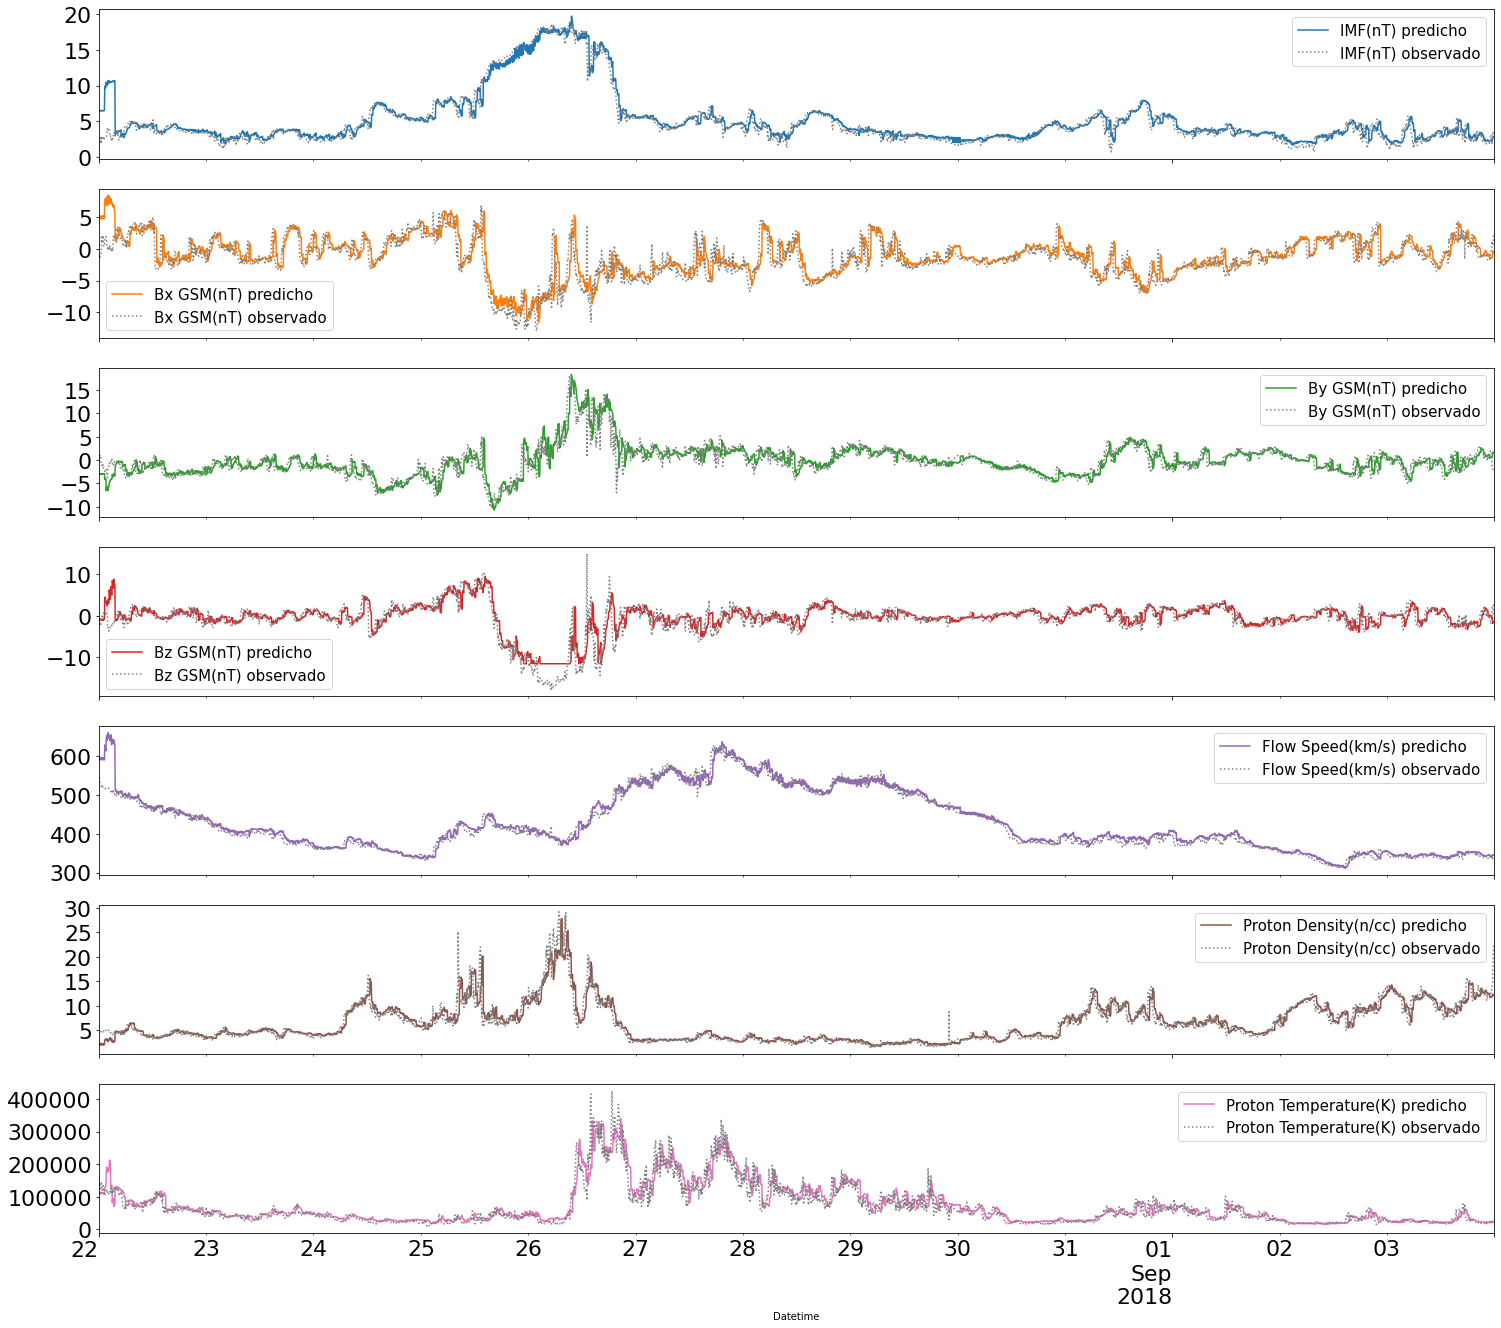

In [ ]:
#Grafico para ver de manera clara donde se encuentran los NaN en cada variable (discontinuidad)
dataframe=dataframe.astype(float)
plt.rcParams.update({'legend.fontsize': 15})
ax = dataframe.plot(subplots = True, figsize=(25, 25), markersize = 20)
df_tormenta.plot(ax = ax, subplots = True, figsize=(25, 20), linestyle = ':', color = 'grey', sharex = False,
                        fontsize=22, markersize = 20)